In [1]:
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

np.random.seed(42)

/Users/taiwoalabi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_FILE = "/Users/taiwoalabi/Downloads/winemag-data-130k-v2.csv"

In [3]:
Marie= pd.read_csv(INPUT_FILE)



In [73]:
Marie.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
#Marie["Feature1"] = []


for ii in range(len(Marie)):
    
    Marie.loc[ii,"Feature1"] = str(Marie.loc[ii,"description"]) + "," + str(Marie.loc[ii,"country"]) + "," + str(Marie.loc[ii,"province"]) \
    + str(Marie.loc[ii,"variety"]) + "," + str(Marie.loc[ii,"winery"])

In [5]:
for ii in range(len(Marie)):
    Marie.loc[ii,"Points1"] = int(Marie.loc[ii,"points"])/100
    

### Generating the Parts of Speech tagging sequence and then dumping them into Feature_#2 ###

In [79]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/taiwoalabi/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [80]:
from nltk.tag.api import TaggerI

In [81]:
text1= nltk.word_tokenize("Taiwo is an ugly piece of crap")

In [82]:
nltk.pos_tag(text1)

[('Taiwo', 'NNP'),
 ('is', 'VBZ'),
 ('an', 'DT'),
 ('ugly', 'JJ'),
 ('piece', 'NN'),
 ('of', 'IN'),
 ('crap', 'NN')]

In [83]:
text2 = nltk.word_tokenize(Marie.loc[1,"description"])

In [84]:
yy = nltk.pos_tag(text2)

In [85]:
yy[1]

('is', 'VBZ')

In [86]:
yy[1][1]

'VBZ'

### -- POS Tags to extract all the adjectives and Nouns for Natural Langauge Processing --  ###

In [6]:
Adjective_Nouns= ['JJ', 'JJR','JJS','NN', 'NNS', 'NNP', 'NNPS', 'VBN' ]
list2 =[]
#for ii in yy:
    #if ii[1] in Adjective_Nouns:
        #list2.append(ii[0])
ZZ= [ii[0] for ii in yy if ii[1] in Adjective_Nouns]

NameError: name 'yy' is not defined

In [88]:
ZZ

['ripe',
 'fruity',
 'wine',
 'smooth',
 'structured',
 'Firm',
 'tannins',
 'filled',
 'juicy',
 'red',
 'berry',
 'fruits',
 'freshened',
 'acidity',
 'drinkable']

In [89]:
' '.join(list2)

''

In [8]:
Adjective_Nouns= ['JJ', 'JJR','JJS','NN', 'NNS', 'NNP', 'NNPS', 'VBN' ]
for ii in range(len(Marie)):
    Z= nltk.pos_tag(nltk.word_tokenize(Marie.loc[ii, "description"]))
    ZZ= [ii[0] for ii in Z if ii[1] in Adjective_Nouns]
    Marie.loc[ii,"POS-Tag"]= ' '.join(ZZ)
    

In [9]:
#INPUT_FILE = "/Users/taiwoalabi/Downloads/sentiment_labelled_sentences/amazon_cells_labelled.txt"
#INPUT_FILE = "/Users/taiwoalabi/Downloads/sentiment_labelled_sentences/yelp_labelled.txt"
#INPUT_FILE = "/Users/taiwoalabi/Downloads/sentiment_labelled_sentences/imdb_labelled.txt"
VOCAB_SIZE = 5000
EMBED_SIZE = 500
NUM_FILTERS = 1024
NUM_WORDS = 70
BATCH_SIZE = 100
NUM_EPOCHS = 10

In [10]:
counter = collections.Counter()
maxlen = 0
for iii in range(len(Marie)):
    sentence = Marie['POS-Tag'][iii]
    words = [x.lower() for x in nltk.word_tokenize(sentence)]
    
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [11]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [12]:

xs, ys = [], []

for iii in range(len(Marie)):
    sentence = Marie['POS-Tag'][iii]
    label = float(Marie['Points1'][iii])
    words = [x.lower() for x in nltk.word_tokenize(sentence)]
    ys.append((label))
    wids = [word2index[word] for word in words]
    xs.append(wids)

X = pad_sequences(xs, maxlen=maxlen)


In [ ]:
#Y = np_utils.to_categorical(ys)

In [13]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, ys, test_size=0.3, random_state=50)

In [14]:
from keras.layers import Flatten
from keras.constraints import maxnorm

model = Sequential()
model.add(Embedding(vocab_size, EMBED_SIZE, input_length=maxlen))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=(maxlen- 50),activation="relu"))
model.add(Dropout(0.2))
model.add(Conv1D(512, kernel_size = 2, activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())


model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(1))
print(model.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 500)           2500500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 71, 500)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 51, 1024)          10753024  
_________________________________________________________________
dropout_1 (Dropout)          (None, 51, 1024)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 512)           1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 51, 512)           0         
___________________________________________________________

In [15]:
from keras import optimizers
NUM_EPOCHS = 10
lr = 0.01
decay = lr/NUM_EPOCHS
sgd = optimizers.SGD(lr= lr, decay=decay, momentum = 0.9, nesterov = False)

### Creating a custom back-end flow metric for the calculation of the Predictive accuracy using the Keras framework WOOOOHOOOOO!!!! ####

In [16]:
import keras.backend as K
def RawDiff(y_true, y_pred):
    return ((y_pred)- (y_true))

In [17]:
model.compile(loss="mean_squared_error", optimizer=sgd, metrics=["mae", "acc", RawDiff])
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, Ytest))

scores = model.evaluate(Xtest, Ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 90979 samples, validate on 38992 samples
Epoch 1/10
90979/90979 [==============================] - 10939s 120ms/step - loss: 0.0051 - mean_absolute_error: 0.0396 - acc: 1.5388e-04 - RawDiff: -0.0046 - val_loss: 0.0018 - val_mean_absolute_error: 0.0354 - val_acc: 1.0259e-04 - val_RawDiff: -0.0317
Epoch 2/10
90979/90979 [==============================] - 7883s 87ms/step - loss: 9.4961e-04 - mean_absolute_error: 0.0247 - acc: 1.6487e-04 - RawDiff: -4.7037e-04 - val_loss: 0.0016 - val_mean_absolute_error: 0.0330 - val_acc: 1.0259e-04 - val_RawDiff: -0.0278
Epoch 3/10
90979/90979 [==============================] - 7731s 85ms/step - loss: 8.5808e-04 - mean_absolute_error: 0.0235 - acc: 1.6487e-04 - RawDiff: -3.0396e-04 - val_loss: 0.0015 - val_mean_absolute_error: 0.0315 - val_acc: 1.0259e-04 - val_RawDiff: -0.0255
Epoch 4/10
90979/90979 [==============================] - 8686s 95ms/step - loss: 8.2426e-04 - mean_absolute_error: 0.0231 - acc: 1.6487e-04 - RawDiff: -1.8159e-04 - val_

In [118]:
scores = model.evaluate(Xtest, Ytest, verbose=0)


Accuracy: 0.01%


In [119]:
print(scores)

[0.00010260028693904601, 0.0003884678013170093, 0.9998974148543291, 0.0001788175090814753]


In [120]:
print("Accuracy: %.2f%%" % (scores[2]*100))

Accuracy: 99.99%


In [121]:
print("Raw-differential: {}".format(scores[3]))

Raw-differential: 0.0001788175090814753


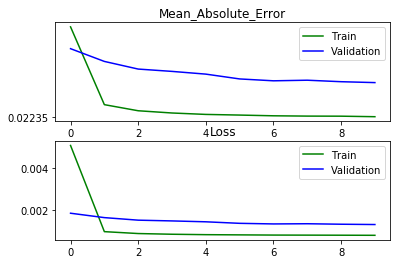

In [19]:
#plt.subplot(211)
#plt.title("Accuracy")
#plt.plot(history.history["acc"], color="g", label="Train")
#plt.plot(history.history["val_acc"], color="b", label="Validation")
#plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")


plt.subplot(211)
plt.title("Mean_Absolute_Error")
plt.plot(history.history["mean_absolute_error"], color="g", label="Train")
plt.plot(history.history["val_mean_absolute_error"], color="b", label="Validation")
plt.yticks(np.arange(min(history.history["mean_absolute_error"]), 0.09))
plt.legend(loc="best")

#plt.tight_layout()
plt.show()